In [1]:
import pickle
import math
import random
import seaborn as sns
from utils import label, clean, measure_distance, save_subsets,\
    generate_hard_split, combine_folds
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import pytreebank
from nltk import Tree
sns.set_context("talk")

## 1. Create the ranking, story subsets and hard splits to file

In [7]:
sst = pytreebank.load_sst()
sst = [' '.join(str(l).lower().replace("(", " ( ").replace(")", " ) ").split())
       for l in sst["train"] + sst["dev"] + sst["test"]]

for taught in [False, True]:
    setups = [("size", 25), ("dropout", 0.65), ("beta", 0.01)]
    for setup, weight in setups:
        sentences, similarities = combine_folds(
            weight=weight,
            folds=["fourth", "third", "second", "first"],
            setup=setup,
            bcm_tt=taught,
            num_dims=25)
        assert tuple(sentences) == tuple(sst)
        pickle.dump((similarities, {' '.join(clean(s)): x for s, x in zip(sentences, similarities)}),
                     open(f"rankings/ranking_setup={setup}_taught={taught}.pickle", 'wb'))
        print(f"rankings/ranking_setup={setup}_taught={taught}.pickle")
        save_subsets(similarities, sentences, setup, taught)
        generate_hard_split(similarities, sentences, setup, taught)

KeyboardInterrupt: 

## 2. Visualise ranking & examples for paper

In [2]:
def print_examples(sentences, similarities):
    glove = pickle.load(open("../../../archive/noncompositionality_metric_emnlp22/data/pickled_data/embeddings.pickle", 'rb'))
    indices = list(np.argsort(similarities))
    similarities = [indices.index(i)/len(indices) for i in range(len(similarities))]
    examples = defaultdict(list)
    for s, x in zip(sentences, similarities):
        tree = Tree.fromstring(s)
        root = tree.label()
        left = tree[0].label()
        right = tree[1].label()
        if 10 <= len(clean(s)) <= 15 and all([w in glove for w in clean(s)]):
            examples[math.ceil(x*10)].append((x, s, root))

    for subcat in sorted(examples.keys()):
        for r, s, x in sorted(random.sample(examples[subcat], 1)):
            tree = Tree.fromstring(s)
            print(f"{r:.2f} & {x} & {' '.join(clean(str(tree[0])))}" + " " + " ".join(clean(str(tree[1]))) + "\\\\")

In [3]:
def visualise(similarities, setup, seed, title):
    random.seed(seed)
    indices = list(np.argsort(similarities))
    similarities = [indices.index(i)/len(indices) for i in range(len(similarities))]
    hard = {tuple(x.split("\t")[4].lower().split()): x.split("\t")[5].strip().split("::")
            for x in open("../../data/sentiment_hard/annotated.txt").readlines()}
    per_phenomenon = defaultdict(list)
    for s, x in zip(sentences, similarities):

        if tuple(clean(s)) in hard:
            for y in hard[tuple(clean(s))]:
                if y not in ["positive", "negative", "neutral"]:
                    per_phenomenon[(y, "theirs")].append(x)
        for cat in label(s):
            per_phenomenon[(cat, "mine")].append(x)

    x, y, text = [], [], []
    for cat in per_phenomenon:
        if len(per_phenomenon[cat]) >= 20:
            x.append(np.mean(per_phenomenon[cat]))
            text.append(cat)

    plt.figure(figsize=(22, 0.4))
    sns.set_context("talk")
    ax = sns.scatterplot(x=[np.mean(similarities)], y=[1], color="white")
    sns.scatterplot(x=x, y=[1]*len(x), color="white")
    for x_, (c_, o) in zip(x, text):
        if setup == "size" and "bcm-pp" in title:
            if c_ == "negative":
                x_ = 0.4654345414898104
            elif c_ == "attenuation":
                x_ = 0.520128702592219
            elif c_ == "idioms":
                x_ = 0.5409939547307746
            elif c_ == "morphology":
                x_ = 0.5590327691489556
            elif c_ == "neutral":
                x_ = 0.5915370454474097
            elif c_ == "mixed":
                x_ = 0.5750697826003604
            elif c_ == "comparative":
                x_ = 0.5333005118150628
        elif setup == "size" and "bcm-tt" in title:
            if c_ == "neutral":
                x_ = 0.5870370454474097
            elif c_ == "in_between":
                x_ = 0.482023321698209775
            elif c_ == "amplified":
                x_ = 0.48730967946014336
            elif c_ == "negative":
                x_ = 0.47216368351624684
            elif c_ == "idioms":
                x_ = 0.47666610431604106
        elif setup == "dropout" and "bcm-pp" in title:
            if c_ == "morphology":
                x_ = 0.5233516402911999
            elif c_ == "negative":
                x_ = 0.5049939876342687
            elif c_ == "attenuation":
                x_ = 0.53302672864882904
        elif setup == "beta" and "bcm-pp" in title:
            if c_ == "desirable-element":
                x_ = 0.4876742115375603 
            elif c_ == "amplification":
                x_ = 0.36351897933361454
            elif c_ == "neutral":
                x_ = 0.537134014833498
            elif c_ == "switch":
                x_ = 0.5407207833907022
            elif c_ == "strong":
                x_ = 0.5447202305637565
            elif c_ == "neutral<->polarised":
                x_ = 0.5650998272780222 
            elif c_ == "amplified":
                x_ = 0.4916009067903838
        elif setup == "beta" and "bcm-tt" in title:
            if c_ == "negated":
                x_ = 0.5899056618828866
            elif c_ == "continuity (neutral)":
                x_ = 0.62552949301881
            elif c_ == "no-sentiment":
                x_ = 0.63003620132152398
            elif c_ == "world-knowledge":
                x_ = 0.6214198047839971
            elif c_ == "switch":
                x_ = 0.6174690820533054
        elif setup == "dropout" and "bcm-tt" in title:
            if c_ == "morphology":
                x_ = 0.4566482863587185
            elif c_ == "strong":
                x_ = 0.5899036974553634
            elif c_ == "switch":
                x_ = 0.595003904708779473

        if o == "mine":
            plt.text(x_, 1, c_, rotation=90)
        elif o == "theirs":
            plt.text(x_, 1, c_, rotation=90, color="grey")
            
        print(x_, c_)

    # plt.legend(bbox_to_anchor=(1, 1.05))
    sns.despine(top=True, right=True, bottom=True, left=True)
    x = np.linspace(min(x), max(x), 1000)
    y = [0.9]*len(x)
    c = np.tan(x)
    sns.scatterplot(x=x, y=y, hue=c, marker='_', s=10000, palette="crest_r")
    plt.yticks([])
    plt.legend([], [], frameon=False)
    if setup == "size" and "post_processing" in title:
        plt.text(min(x)-0.025, 0.6, r"$most\ compositional$")
        plt.text(max(x)-0.025, 0.6, r"$least\ compositional$")
    #plt.text(min(x), 1.7, title)
    plt.savefig(f"figures/continuum_{title}.pdf", bbox_inches="tight")
    plt.show()

rankings/ranking_setup=size_taught=False.pickle
0.07 & 3 & tsai convincingly paints a specifically urban sense of disassociation here .\\
0.17 & 0 & the film desperately sinks further and further into comedy futility .\\
0.21 & 3 & a cop story that understands the medium amazingly well .\\
0.40 & 3 & one scarcely needs the subtitles to enjoy this colorful action farce .\\
0.42 & 1 & the entire movie is about a boring , sad man being boring and sad .\\
0.53 & 2 & not everyone will play the dark , challenging tune taught by the piano teacher .\\
0.66 & 3 & this is the stuff that disney movies are made of .\\
0.75 & 3 & daughter from danang sticks with its subjects a little longer and tells a deeper story\\
0.86 & 2 & not kids , who do n't need the lesson in repugnance .\\
0.98 & 0 & lacks heart , depth and , most of all , purpose .\\
0.443034596875155 in_between
0.5545925198771915 continuity (neutral)
0.5915370454474097 neutral
0.37597455223031984 positive
0.423917475045691 amplification

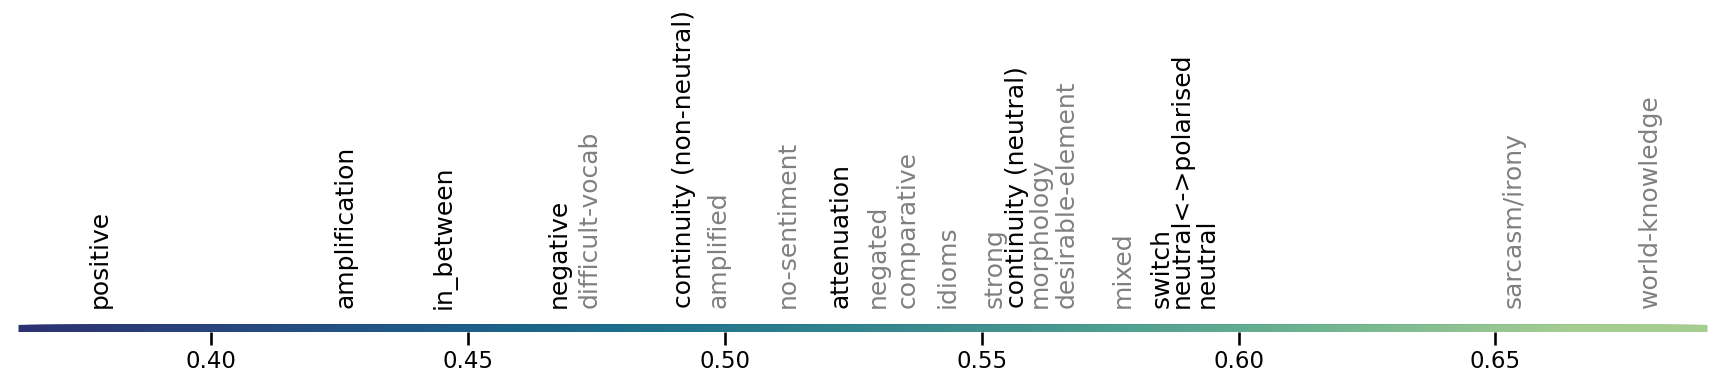

rankings/ranking_setup=dropout_taught=False.pickle
0.09 & 4 & it 's a cool event for the whole family .\\
0.14 & 0 & done in mostly by a weak script that ca n't support the epic treatment .\\
0.20 & 3 & some movies are like a tasty hors-d'oeuvre ; this one is a feast .\\
0.37 & 4 & my oh my , is this an invigorating , electric movie .\\
0.41 & 3 & its director 's most substantial feature for some time .\\
0.51 & 4 & the modern master of the chase sequence returns with a chase to end all chases\\
0.62 & 3 & like its bizarre heroine , it irrigates our souls .\\
0.78 & 1 & sadly , ` garth ' has n't progressed as nicely as ` wayne . '\\
0.86 & 2 & you 're too conscious of the effort it takes to be this spontaneous .\\
0.95 & 0 & a film of empty , fetishistic violence in which murder is casual and fun .\\
0.467991567554714 in_between
0.5283450499945668 continuity (neutral)
0.5478639775427718 neutral
0.41448722707995034 positive
0.44215063967383667 amplification
0.5153094309212508 continuity

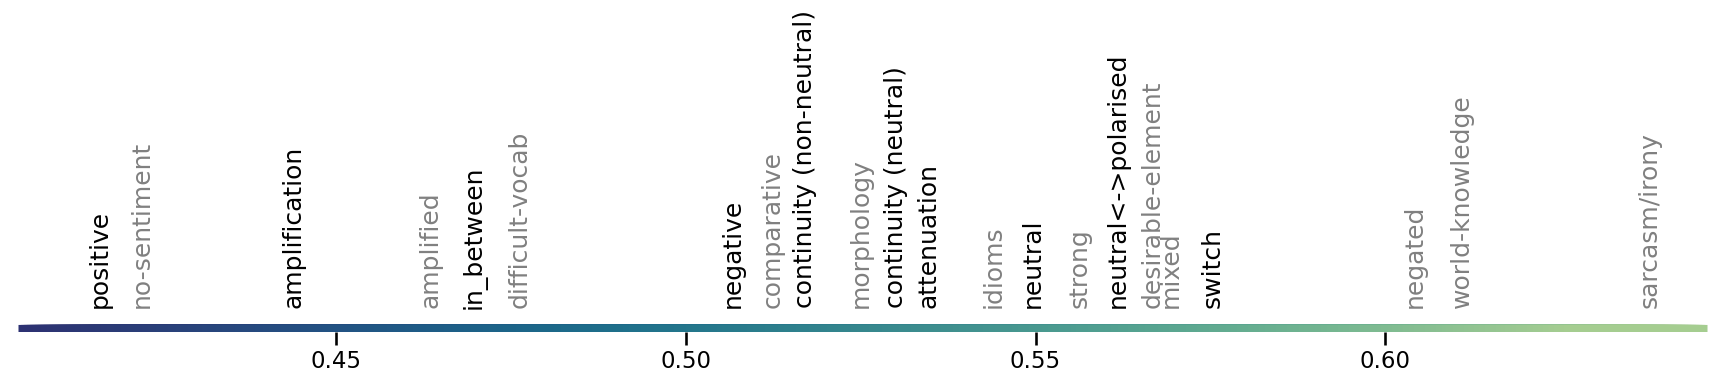

rankings/ranking_setup=beta_taught=False.pickle
0.07 & 4 & highly recommended viewing for its courage , ideas , technical proficiency and great acting .\\
0.18 & 3 & it manages to squeeze by on angelina jolie 's surprising flair for self-deprecating comedy .\\
0.25 & 1 & goes on and on to the point of nausea .\\
0.38 & 3 & the best part about `` gangs '' was daniel day-lewis .\\
0.44 & 2 & a dopey movie clothed in excess layers of hipness .\\
0.51 & 2 & a perplexing example of promise unfulfilled , despite many charming moments .\\
0.64 & 0 & the entire film is one big excuse to play one lewd scene after another .\\
0.79 & 1 & the problematic characters and overly convenient plot twists foul up shum 's good intentions .\\
0.82 & 3 & the jabs it employs are short , carefully placed and dead-center .\\
0.92 & 2 & then nadia 's birthday might not have been such a bad day after all .\\
0.4759091032207706 in_between
0.52759526962441 continuity (neutral)
0.537134014833498 neutral
0.358746768

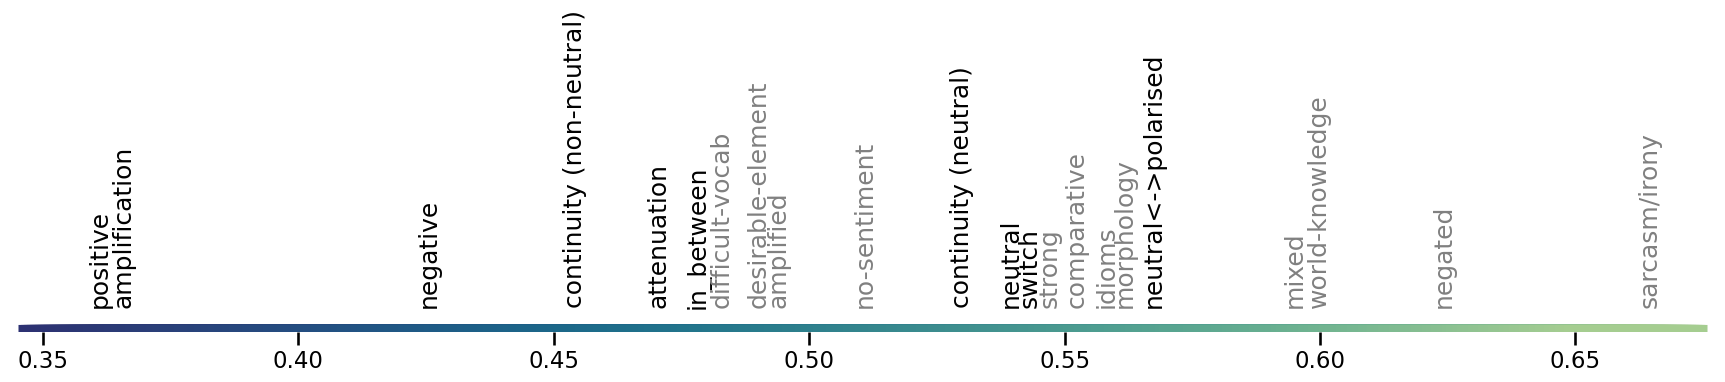

rankings/ranking_setup=size_taught=True.pickle
0.00 & 3 & the story is smart and entirely charming in intent and execution .\\
0.02 & 2 & for single digits kidlets stuart little 2 is still a no brainer .\\
0.17 & 1 & outer-space buffs might love this film , but others will find its pleasures intermittent .\\
0.29 & 3 & although shot with little style , skins is heartfelt and achingly real .\\
0.37 & 3 & a knowing look at female friendship , spiked with raw urban humor .\\
0.50 & 3 & there 's an energy to y tu mamá también .\\
0.57 & 2 & a piquant meditation on the things that prevent people from reaching happiness .\\
0.63 & 3 & too daft by half ... but supremely good natured .\\
0.71 & 1 & the feature-length stretch ... strains the show 's concept .\\
0.88 & 1 & a thriller without thrills and a mystery devoid of urgent questions .\\
0.97 & 1 & the movie does n't generate a lot of energy .\\
0.4820233216982098 in_between
0.6018511526653025 continuity (neutral)
0.5870370454474098 neutra

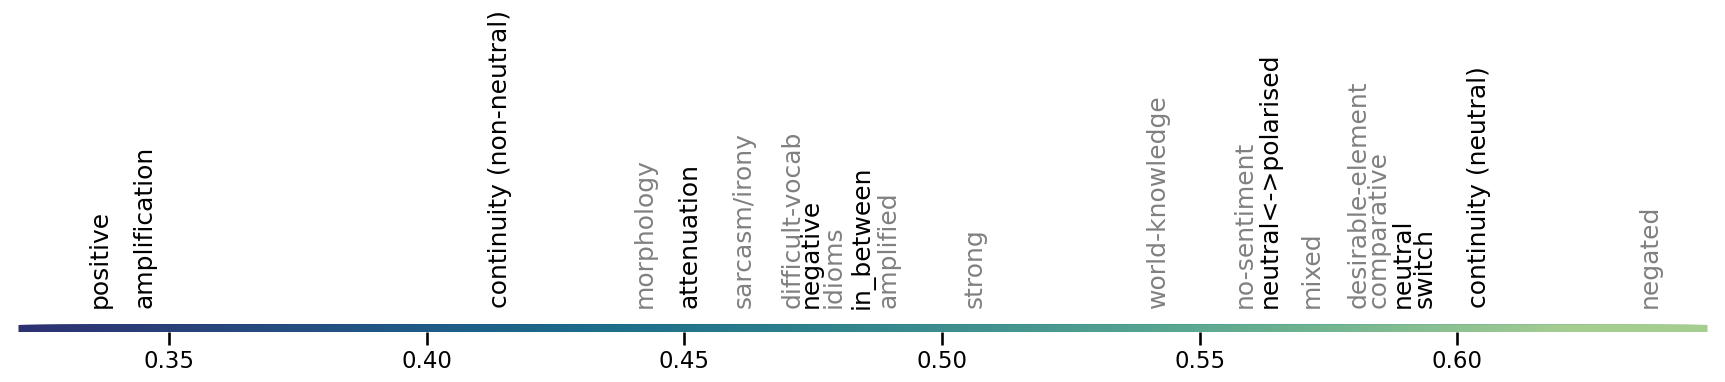

rankings/ranking_setup=dropout_taught=True.pickle
0.03 & 3 & an extremely funny , ultimately heartbreaking look at life in contemporary china .\\
0.14 & 1 & the pretensions -- and disposable story -- sink the movie .\\
0.22 & 4 & that rara avis : the intelligent romantic comedy with actual ideas on its mind .\\
0.39 & 2 & admirable , certainly , but not much fun to watch .\\
0.50 & 1 & the end result is a film that 's neither .\\
0.59 & 2 & throwing it all away for the fleeting joys of love 's brief moment .\\
0.63 & 4 & kids should have a stirring time at this beautifully drawn movie .\\
0.77 & 3 & the obnoxious title character provides the drama that gives added clout to this doc .\\
0.87 & 0 & stitch is a bad mannered , ugly and destructive little **** .\\
0.98 & 0 & there is no pleasure in watching a child suffer .\\
0.4609570255544741 in_between
0.6181214419504971 continuity (neutral)
0.6001936629963889 neutral
0.32594877114154575 positive
0.34492654294952907 amplification
0.39954

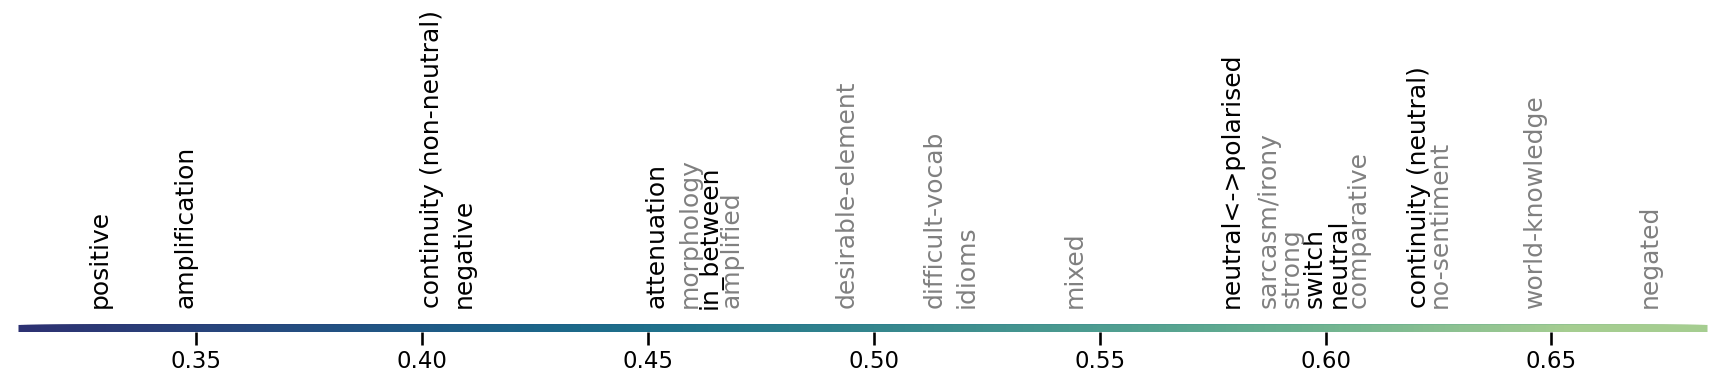

rankings/ranking_setup=beta_taught=True.pickle
0.03 & 4 & quite simply , a joy to watch and -- especially -- to listen to .\\
0.14 & 1 & a fake street drama that keeps telling you things instead of showing them .\\
0.22 & 1 & it tries too hard , and overreaches the logic of its own world .\\
0.34 & 1 & plays less like a coming-of-age romance than an infomercial .\\
0.48 & 4 & it 's one of the most honest films ever made about hollywood .\\
0.52 & 3 & a low-key labor of love that strikes a very resonant chord .\\
0.69 & 3 & it 's never laugh-out-loud funny , but it is frequently amusing .\\
0.71 & 3 & a meditation on faith and madness , frailty is blood-curdling stuff .\\
0.81 & 1 & a beautifully shot but dull and ankle-deep ` epic . '\\
0.91 & 2 & it uses the pain and violence of war as background material for color .\\
0.46882151546927375 in_between
0.62552949301881 continuity (neutral)
0.6025269781313201 neutral
0.3219316142330863 positive
0.34001827639533244 amplification
0.41087884

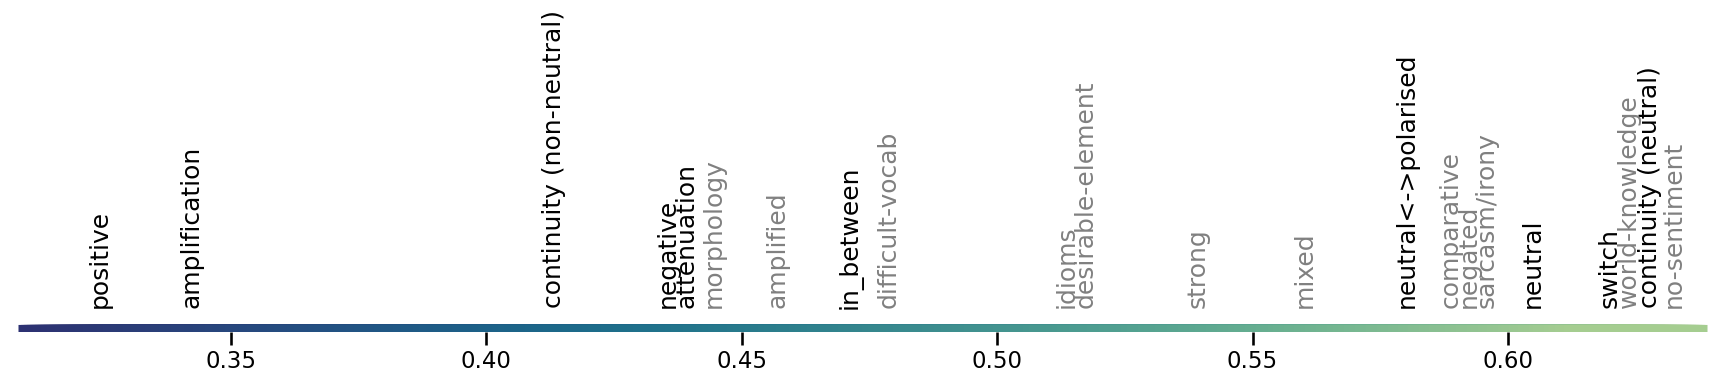

In [6]:
import random
random.seed(1)
sst = pytreebank.load_sst()
sst = [' '.join(str(l).lower().replace("(", " ( ").replace(")", " ) ").split()) for l in sst["train"] + sst["dev"] + sst["test"]]
for taught in [False, True]:
    setups = [("size", 25, [1]),
        ("dropout", 0.65, [1]),
        ("beta", 0.01, [6])
    ]

    for setup, w, seeds in setups:
        sentences, similarities = combine_folds(
            weight=w,
            folds=["fourth", "third", "second", "first"],
            setup=setup,
            bcm_tt=taught,
            num_dims=25)
        assert tuple(sentences) == tuple(sst)
        pickle.dump((similarities, {' '.join(clean(s)): x for s, x in zip(sentences, similarities)}),
                     open(f"rankings/ranking_setup={setup}_taught={taught}.pickle", 'wb'))
        print(f"rankings/ranking_setup={setup}_taught={taught}.pickle")
        print_examples(sentences, similarities)
        for seed in seeds:
            visualise(similarities, setup, seed,
                      title=f"metric={'bcm-pp' if not taught else 'bcm-tt'}_bottleneck={setup}")
